<a href="https://colab.research.google.com/github/JhaAkansha/SnowCapMeltAnalysis/blob/main/RS_OEA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install earthengine-api geemap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 27.9 MB/s eta 0:00:00


In [7]:
import ee
ee.Authenticate()
ee.Initialize(project='snowcapmelt')

In [2]:
import datetime
import matplotlib.pyplot as plt

# Arctic and Antarctic regions
arctic = ee.Geometry.Point([-45, 69]).buffer(100000)
antarctic = ee.Geometry.Point([-63.5, -73]).buffer(100000)

# NDSI calculation function
def calculate_ndsi(image, green_band, swir_band):
    ndsi = image.normalizedDifference([green_band, swir_band]).rename('NDSI')
    return image.addBands(ndsi)

# Safe median for empty image collections
def safe_median(img_collection):
    size = img_collection.size()
    return ee.Image(ee.Algorithms.If(
        size.eq(0),
        ee.Image(0),  # fallback
        img_collection.median()
    ))

# Main function to compute yearly snow cover
def get_yearly_snow_cover(start_year, end_year, region, platform='Landsat'):
    yearly_snow_stats = []

    for year in range(start_year, end_year + 1):
        start = ee.Date.fromYMD(year, 6, 1)
        end = ee.Date.fromYMD(year, 9, 30)

        if platform == 'Landsat':
            # Filter collections
            l5 = ee.ImageCollection("LANDSAT/LT05/C02/T1_L2") \
                .filterDate(start, end).filterBounds(region)
            l7 = ee.ImageCollection("LANDSAT/LE07/C02/T1_L2") \
                .filterDate(start, end).filterBounds(region)
            l8 = ee.ImageCollection("LANDSAT/LC08/C02/T1_L2") \
                .filterDate(start, end).filterBounds(region)
            l9 = ee.ImageCollection("LANDSAT/LC09/C02/T1_L2") \
                .filterDate(start, end).filterBounds(region)

            # Merge all
            merged = l5.merge(l7).merge(l8).merge(l9)

            # Apply NDSI using SR_B3 (green) and SR_B7 (SWIR for Landsat 5/7/8/9)
            processed = merged.map(lambda img: calculate_ndsi(img, 'SR_B3', 'SR_B7'))

        else:
            raise ValueError("Only Landsat supported for now.")

        # Threshold NDSI to get snow
        snow_ndsi = processed.map(lambda img: img.select('NDSI').gt(0.4))

        # Handle empty collection with safe median
        snow_masked = safe_median(snow_ndsi)

        # Multiply snow mask by pixel area
        pixel_area = snow_masked.multiply(ee.Image.pixelArea())

        # Reduce to get total snow-covered area in the region
        stats = pixel_area.reduceRegion(
            reducer=ee.Reducer.sum(),
            geometry=region,
            scale=30,
            maxPixels=1e13
        )

        # Safely extract snow-covered area in km²
        snow_value = ee.Algorithms.If(
            stats.contains('NDSI'),
            ee.Number(stats.get('NDSI')).divide(1e6),
            0
        )

        yearly_snow_stats.append(snow_value)

    return ee.List(yearly_snow_stats)

# === RUNNING FOR ARCTIC AND ANTARCTIC === #
years = list(range(2000, 2025))

print("Calculating Arctic snow cover...")
arctic_snow = get_yearly_snow_cover(2000, 2024, arctic, platform='Landsat')
arctic_area = arctic_snow.getInfo()  # converts ee.List to Python list

print("Calculating Antarctic snow cover...")
antarctic_snow = get_yearly_snow_cover(2000, 2024, antarctic, platform='Landsat')
antarctic_area = antarctic_snow.getInfo()
print("Arctic Snow Area (km²):", arctic_area)
print("Antarctic Snow Area (km²):", antarctic_area)

Calculating Arctic snow cover...
Calculating Antarctic snow cover...
Arctic Snow Area (km²): [11572.203509698358, 11503.952528084863, 11585.101621871609, 9820.419660450183, 11510.572300487429, 9497.523122354683, 11697.68416731777, 11675.539237948286, 11367.18616914419, 11839.847575026024, 12802.946528815413, 12639.477811680374, 12638.870749817104, 13291.38025356888, 12858.674828907719, 12887.095098216574, 13010.43737340373, 12894.582256850588, 13111.571094806384, 12985.646817845318, 12938.138253421708, 12996.438059993206, 12980.568057927965, 12920.876506075194, 13014.287790172728]
Antarctic Snow Area (km²): [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


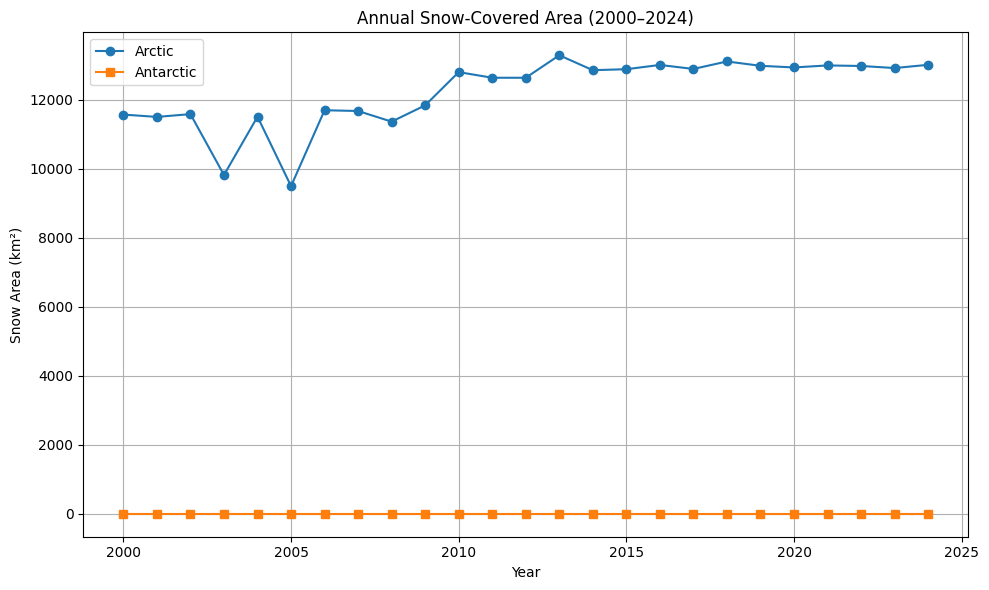

In [3]:
plt.figure(figsize=(10, 6))
plt.plot(years, arctic_area, label='Arctic', marker='o')
plt.plot(years, antarctic_area, label='Antarctic', marker='s')
plt.title("Annual Snow-Covered Area (2000–2024)")
plt.ylabel("Snow Area (km²)")
plt.xlabel("Year")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


Processing 2015...
  arctic...OK
  Greenland...OK
  Svalbard...OK
  Canadian Arctic...OK
  Antarctic Peninsula...OK
  Patagonia...OK

Processing 2016...
  arctic...OK
  Greenland...OK
  Svalbard...OK
  Canadian Arctic...OK
  Antarctic Peninsula...OK
  Patagonia...OK

Processing 2017...
  arctic...OK
  Greenland...OK
  Svalbard...OK
  Canadian Arctic...OK
  Antarctic Peninsula...OK
  Patagonia...OK

Processing 2018...
  arctic...OK
  Greenland...OK
  Svalbard...OK
  Canadian Arctic...OK
  Antarctic Peninsula...OK
  Patagonia...OK

Processing 2019...
  arctic...OK
  Greenland...OK
  Svalbard...OK
  Canadian Arctic...OK
  Antarctic Peninsula...OK
  Patagonia...OK

Processing 2020...
  arctic...OK
  Greenland...OK
  Svalbard...OK
  Canadian Arctic...OK
  Antarctic Peninsula...OK
  Patagonia...OK

Processing 2021...
  arctic...OK
  Greenland...OK
  Svalbard...OK
  Canadian Arctic...OK
  Antarctic Peninsula...OK
  Patagonia...OK

Processing 2022...
  arctic...OK
  Greenland...OK
  Svalbard.

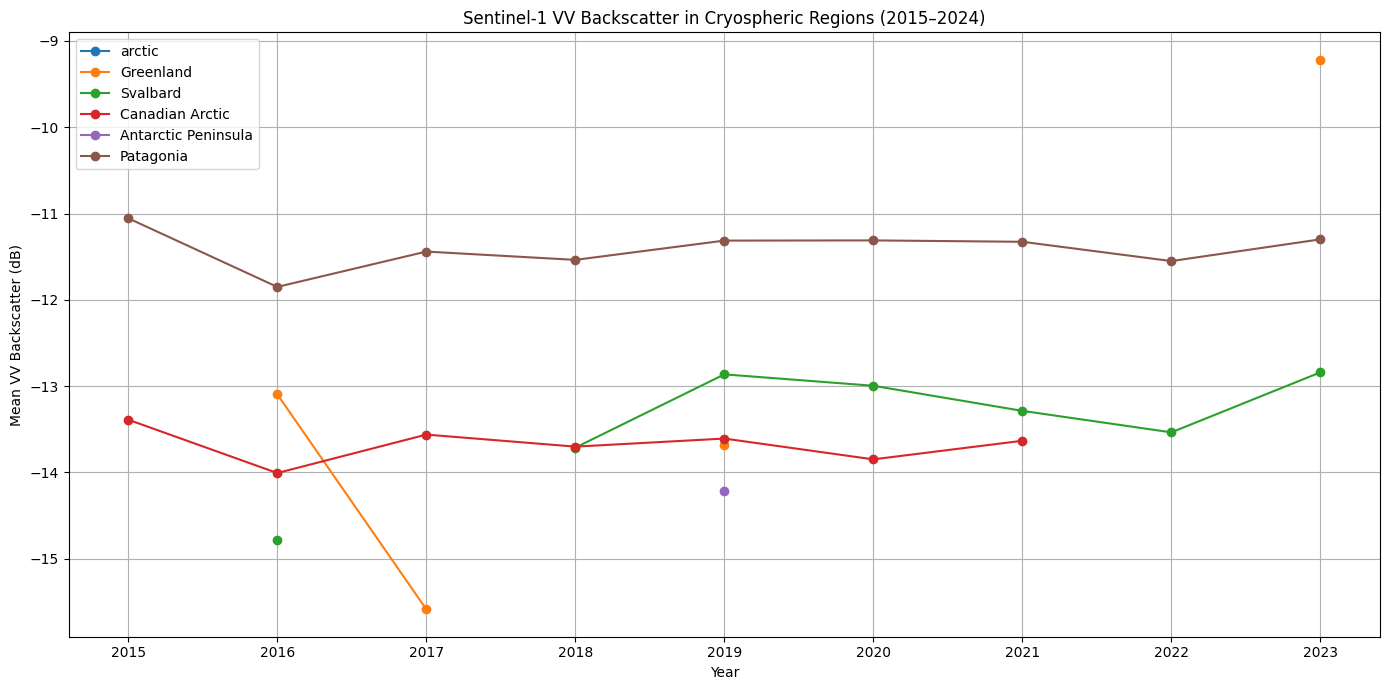

In [4]:
#Mean VV backscatter (dB)	Higher = dry snow or ice, Lower = wet/melted

# Years to analyze
years = list(range(2000, 2025))
# Define regions as polygons
regions = {
    'arctic': ee.Geometry.Polygon([[[-180, 66.5], [-180, 90], [180, 90], [180, 66.5], [-180, 66.5]]]),
    'Greenland': ee.Geometry.Polygon([[[-52, 60], [-52, 80], [-30, 80], [-30, 60], [-52, 60]]]),
    'Svalbard': ee.Geometry.Polygon([[[10, 76], [10, 82], [35, 82], [35, 76], [10, 76]]]),
    'Canadian Arctic': ee.Geometry.Polygon([[[-100, 65], [-100, 75], [-70, 75], [-70, 65], [-100, 65]]]),
    'Antarctic Peninsula': ee.Geometry.Polygon([[[-75, -75], [-75, -60], [-50, -60], [-50, -75], [-75, -75]]]),
    'Patagonia': ee.Geometry.Polygon([[[-75, -55], [-75, -45], [-70, -45], [-70, -55], [-75, -55]]]),
}

# Years to analyze
years = list(range(2015, 2024))

# Get Sentinel-1 VV backscatter
def get_s1_vv_mean(region, year):
    start = ee.Date.fromYMD(year, 1, 1)
    end = ee.Date.fromYMD(year, 12, 31)

    s1 = ee.ImageCollection('COPERNICUS/S1_GRD') \
        .filterDate(start, end) \
        .filterBounds(region) \
        .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VV')) \
        .select('VV')

    if s1.size().getInfo() == 0:
        return None

    median = s1.median().clip(region)
    stats = median.reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=region,
        scale=5000,
        maxPixels=1e13,
        tileScale=8
    )
    return stats.get('VV').getInfo()

# Results dictionary
results = {name: [] for name in regions.keys()}

# Process each region
for year in years:
    print(f"\nProcessing {year}...")
    for name, geom in regions.items():
        try:
            print(f"  {name}...", end='')
            vv = get_s1_vv_mean(geom, year)
            results[name].append(vv)
            print("OK")
        except Exception as e:
            print(f"error ({e})")
            results[name].append(None)

# ---- Plot results ----
plt.figure(figsize=(14, 7))
for name, values in results.items():
    plt.plot(years, values, marker='o', label=name)

plt.title('Sentinel-1 VV Backscatter in Cryospheric Regions (2015–2024)')
plt.xlabel('Year')
plt.ylabel('Mean VV Backscatter (dB)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
#Landsat does not cover most of the Antarctic interior due to orbital constraints.
#most imagery is cloud-covered or unavailable during Antarctic winter.

In [ ]:
#Sentinel 1 is not optical and therefore does not give NDSI hence we use backscatter

In [5]:
#Getting data for 2000 to 2014 from MODIS since Sentinel-1 does not have data before 2015
#MODIS gives fraction of area snow-covered: 0 (none) to 1 (fully covered). Sentinel-1 VV gives backscatter (dB): useful for wet snow / ice transitions.


Processing 2017...
  Greenland...✔
  Svalbard...✔
  Canadian Arctic...✔
  Antarctic Peninsula...✔
  Patagonia...✔

Processing 2018...
  Greenland...✔
  Svalbard...✔
  Canadian Arctic...✔
  Antarctic Peninsula...✔
  Patagonia...✔

Processing 2019...
  Greenland...✔
  Svalbard...✔
  Canadian Arctic...✔
  Antarctic Peninsula...✔
  Patagonia...✔

Processing 2020...
  Greenland...✔
  Svalbard...✔
  Canadian Arctic...✔
  Antarctic Peninsula...✔
  Patagonia...✔

Processing 2021...
  Greenland...✔
  Svalbard...✔
  Canadian Arctic...✔
  Antarctic Peninsula...✔
  Patagonia...✔

Processing 2022...
  Greenland...✔
  Svalbard...✔
  Canadian Arctic...✔
  Antarctic Peninsula...✔
  Patagonia...✔

Processing 2023...
  Greenland...✔
  Svalbard...✔
  Canadian Arctic...✔
  Antarctic Peninsula...✔
  Patagonia...✔


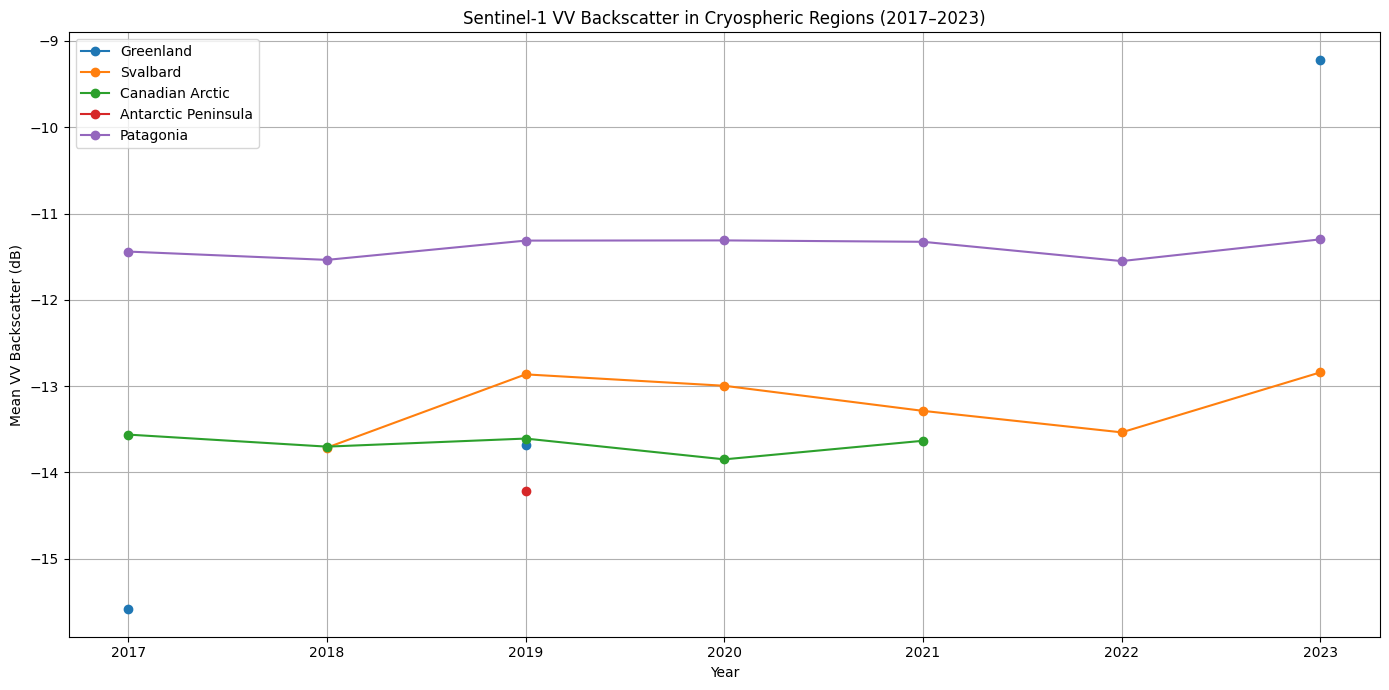

In [8]:
import ee
import matplotlib.pyplot as plt

# Define regions as polygons
regions = {
    'Greenland': ee.Geometry.Polygon([[[-52, 60], [-52, 80], [-30, 80], [-30, 60], [-52, 60]]]),
    'Svalbard': ee.Geometry.Polygon([[[10, 76], [10, 82], [35, 82], [35, 76], [10, 76]]]),
    'Canadian Arctic': ee.Geometry.Polygon([[[-100, 65], [-100, 75], [-70, 75], [-70, 65], [-100, 65]]]),
    'Antarctic Peninsula': ee.Geometry.Polygon([[[-75, -75], [-75, -60], [-50, -60], [-50, -75], [-75, -75]]]),
    'Patagonia': ee.Geometry.Polygon([[[-75, -55], [-75, -45], [-70, -45], [-70, -55], [-75, -55]]]),
}

# Years to analyze
years = list(range(2017, 2024))

# Get Sentinel-1 VV backscatter
def get_s1_vv_mean(region, year):
    start = ee.Date.fromYMD(year, 1, 1)
    end = ee.Date.fromYMD(year, 12, 31)

    s1 = ee.ImageCollection('COPERNICUS/S1_GRD') \
        .filterDate(start, end) \
        .filterBounds(region) \
        .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VV')) \
        .select('VV')

    if s1.size().getInfo() == 0:
        return None

    median = s1.median().clip(region)
    stats = median.reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=region,
        scale=5000,
        maxPixels=1e13,
        tileScale=8
    )
    return stats.get('VV').getInfo()

# Results dictionary
results = {name: [] for name in regions.keys()}

# Process each region
for year in years:
    print(f"\nProcessing {year}...")
    for name, geom in regions.items():
        try:
            print(f"  {name}...", end='')
            vv = get_s1_vv_mean(geom, year)
            results[name].append(vv)
            print("OK")
        except Exception as e:
            print(f"Error ({e})")
            results[name].append(None)

# ---- Plot results ----
plt.figure(figsize=(14, 7))
for name, values in results.items():
    plt.plot(years, values, marker='o', label=name)

plt.title('Sentinel-1 VV Backscatter in Cryospheric Regions (2017–2023)')
plt.xlabel('Year')
plt.ylabel('Mean VV Backscatter (dB)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

🔍 Processing region: Greenland
  Year 2000...✅
  Year 2001...✅
  Year 2002...✅
  Year 2003...✅
  Year 2004...✅
  Year 2005...✅
  Year 2006...✅
  Year 2007...✅
  Year 2008...✅
  Year 2009...✅
  Year 2010...✅
  Year 2011...✅
  Year 2012...✅
  Year 2013...✅
  Year 2014...✅
  Year 2015...    ⚠️ 2015 failed: Computation timed out.
—
  Year 2016...    ⚠️ 2016 failed: Computation timed out.
—
  Year 2017...    ⚠️ 2017 failed: Computation timed out.
—
  Year 2018...    ⚠️ 2018 failed: Computation timed out.
—
  Year 2019...    ⚠️ 2019 failed: Computation timed out.
—
  Year 2020...    ⚠️ 2020 failed: Computation timed out.
—
  Year 2021...    ⚠️ 2021 failed: Computation timed out.
—
  Year 2022...    ⚠️ 2022 failed: Computation timed out.
—
  Year 2023...    ⚠️ 2023 failed: Computation timed out.
—
  Year 2024...    ⚠️ 2024 failed: Computation timed out.
—


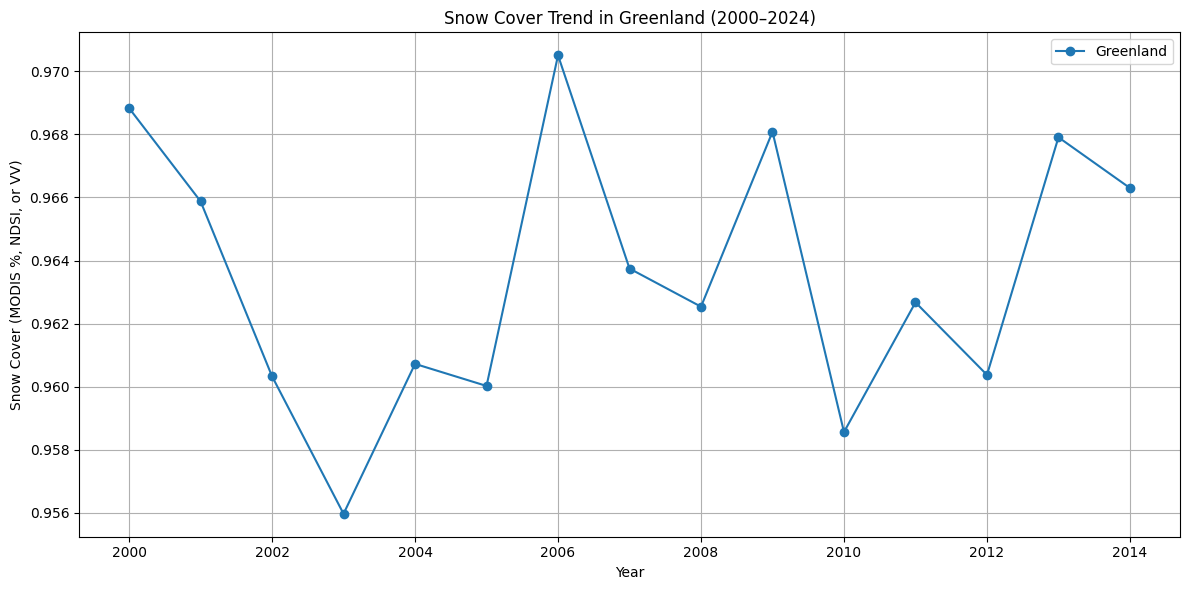

In [3]:
import ee
import matplotlib.pyplot as plt

# Pick ONE region to speed up testing (e.g., Arctic)
region = ee.Geometry.Polygon([[[-52, 59], [-52, 84], [-10, 84], [-10, 59], [-52, 59]]])
region_name = "Greenland"

years = list(range(2000, 2025))
values = []

def get_snow_metric(region, year):
    try:
        if year < 2015:
            modis = ee.ImageCollection('MODIS/006/MOD10A1') \
                .filterDate(f'{year}-01-01', f'{year}-12-31') \
                .filterBounds(region) \
                .select('NDSI_Snow_Cover')
            snow = modis.map(lambda img: img.gt(0).rename('snow')).mean()
            stats = snow.reduceRegion(
                reducer=ee.Reducer.mean(),
                geometry=region,
                scale=5000,
                maxPixels=1e13,
                tileScale=16
            )
            return stats.get('snow').getInfo()

        else:
            s2 = ee.ImageCollection('COPERNICUS/S2_SR') \
                .filterDate(f'{year}-06-01', f'{year}-09-30') \
                .filterBounds(region) \
                .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 20)) \
                .map(lambda img: img.normalizedDifference(['B3', 'B11']).rename('NDSI'))

            if s2.size().getInfo() > 0:
                ndsi = s2.median()
                snow = ndsi.gt(0.1)
                stats = snow.reduceRegion(
                    reducer=ee.Reducer.mean(),
                    geometry=region,
                    scale=20,
                    maxPixels=1e13,
                    tileScale=16
                )
                return stats.get('NDSI').getInfo()

            # Fallback: Sentinel-1 VV
            s1 = ee.ImageCollection('COPERNICUS/S1_GRD') \
                .filterDate(f'{year}-06-01', f'{year}-09-30') \
                .filterBounds(region) \
                .filter(ee.Filter.eq('instrumentMode', 'IW')) \
                .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VV')) \
                .select('VV')

            if s1.size().getInfo() > 0:
                median = s1.median()
                stats = median.reduceRegion(
                    reducer=ee.Reducer.mean(),
                    geometry=region,
                    scale=20,
                    maxPixels=1e13,
                    tileScale=16
                )
                return stats.get('VV').getInfo()

    except Exception as e:
        print(f"    ⚠️ {year} failed: {e}")
        return None


# Process the selected region
print(f"🔍 Processing region: {region_name}")
for year in years:
    print(f"  Year {year}...", end='')
    val = get_snow_metric(region, year)
    values.append(val)
    print("✅" if val is not None else "—")

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(years, values, marker='o', label=region_name)
plt.xlabel('Year')
plt.ylabel('Snow Cover (MODIS %, NDSI, or VV)')
plt.title(f'Snow Cover Trend in {region_name} (2000–2024)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
import ee
import matplotlib.pyplot as plt


# Define regions
regions = {
    'Greenland': ee.Geometry.Polygon([[[-52, 59], [-52, 84], [-10, 84], [-10, 59], [-52, 59]]]),
    'Antarctica': ee.Geometry.Polygon([[[-180, -90], [-180, -60], [180, -60], [180, -90], [-180, -90]]]),
    'Canadian_Arctic': ee.Geometry.Polygon([[[-120, 66], [-120, 80], [-90, 80], [-90, 66], [-120, 66]]]),
    'Svalbard': ee.Geometry.Polygon([[[10, 76], [10, 82], [30, 82], [30, 76], [10, 76]]])
}

# Years to process
years = list(range(2000, 2015))

# Function to get snow metric for a region and year
def get_snow_metric(region_geom, year, region_name):
    try:
        if year < 2015:
            start = f'{year}-12-01' if region_name == "Antarctica" else f'{year}-01-01'
            end = f'{year+1}-02-28' if region_name == "Antarctica" else f'{year}-12-31'

            modis = ee.ImageCollection('MODIS/006/MOD10A1') \
                .filterDate(start, end) \
                .filterBounds(region_geom) \
                .select('NDSI_Snow_Cover')

            snow = modis.map(lambda img: img.gt(0).rename('snow')).mean()
            stats = snow.reduceRegion(
                reducer=ee.Reducer.mean(),
                geometry=region_geom,
                scale=5000,
                maxPixels=1e13,
                tileScale=16
            )
            return stats.get('snow').getInfo()

        else:
            # Sentinel-2: adjust dates for Arctic/Antarctic


In [11]:
import ee
import matplotlib.pyplot as plt
from concurrent.futures import ThreadPoolExecutor, as_completed

# Define target regions
regions = {
    'Greenland': ee.Geometry.Polygon([[[-52, 59], [-52, 84], [-10, 84], [-10, 59], [-52, 59]]]),
    'Antarctica': ee.Geometry.Polygon([[[-180, -90], [-180, -60], [180, -60], [180, -90], [-180, -90]]]),
    'Canadian_Arctic': ee.Geometry.Polygon([[[-120, 66], [-120, 80], [-90, 80], [-90, 66], [-120, 66]]]),
    'Svalbard': ee.Geometry.Polygon([[[10, 76], [10, 82], [30, 82], [30, 76], [10, 76]]])
}

# Years to process
years = list(range(2000, 2025))

# Function to compute snow metric for a single year and region
def get_snow_metric(region_geom, year, region_name):
    try:
        if year < 2015:
            # MODIS data
            start = f'{year}-12-01' if region_name == "Antarctica" else f'{year}-01-01'
            end = f'{year+1}-02-28' if region_name == "Antarctica" else f'{year}-12-31'

            modis = ee.ImageCollection('MODIS/006/MOD10A1') \
                .filterDate(start, end) \
                .filterBounds(region_geom) \
                .select('NDSI_Snow_Cover')

            snow = modis.map(lambda img: img.gt(0).rename('snow')).mean()
            stats = snow.reduceRegion(
                reducer=ee.Reducer.mean(),
                geometry=region_geom,
                scale=5000,
                maxPixels=1e13,
                tileScale=16
            )
            return year, stats.get('snow').getInfo()

        else:
            # Sentinel-2 data
            start = f'{year}-12-01' if region_name == "Antarctica" else f'{year}-06-01'
            end = f'{year+1}-02-28' if region_name == "Antarctica" else f'{year}-09-30'

            s2 = ee.ImageCollection('COPERNICUS/S2_SR') \
                .filterDate(start, end) \
                .filterBounds(region_geom) \
                .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 50)) \
                .map(lambda img: img.normalizedDifference(['B3', 'B11']).rename('NDSI'))

            if s2.size().getInfo() > 0:
                ndsi = s2.median()
                snow = ndsi.gt(0.1)
                stats = snow.reduceRegion(
                    reducer=ee.Reducer.mean(),
                    geometry=region_geom,
                    scale=100,
                    maxPixels=1e13,
                    tileScale=16
                )
                return year, stats.get('NDSI').getInfo()

            # Fallback: Sentinel-1 VV
            s1 = ee.ImageCollection('COPERNICUS/S1_GRD') \
                .filterDate(start, end) \
                .filterBounds(region_geom) \
                .filter(ee.Filter.eq('instrumentMode', 'IW')) \
                .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VV')) \
                .select('VV')

            if s1.size().getInfo() > 0:
                median = s1.median()
                stats = median.reduceRegion(
                    reducer=ee.Reducer.mean(),
                    geometry=region_geom,
                    scale=100,
                    maxPixels=1e13,
                    tileScale=16
                )
                return year, stats.get('VV').getInfo()

    except Exception as e:
        print(f"    Error {region_name} {year} failed: {e}")
        return year, None

# Dictionary to store results
region_results = {}

# Process each region with parallelization over years
for region_name, geom in regions.items():
    print(f"\n🚀 Processing region: {region_name}")
    yearly_values = [None] * len(years)

    with ThreadPoolExecutor(max_workers=5) as executor:
        futures = {
            executor.submit(get_snow_metric, geom, year, region_name): year for year in years
        }
        for future in as_completed(futures):
            year, value = future.result()
            index = years.index(year)
            yearly_values[index] = value
            print(f"  Year {year}... {'OK' if value is not None else '—'}")

    region_results[region_name] = yearly_values

# Plot results
plt.figure(figsize=(14, 7))
for region_name, values in region_results.items():
    plt.plot(years, values, label=region_name, marker='o')

plt.xlabel('Year')
plt.ylabel('Snow Cover (% or backscatter)')
plt.title('Snow Cover Trend (2000–2024)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


🚀 Processing region: Greenland
  Year 2000... OK
  Year 2001... OK
  Year 2003... OK
  Year 2005... OK
  Year 2002... OK
  Year 2004... OK
  Year 2006... OK
  Year 2010... OK
  Year 2009... OK
  Year 2007... OK
  Year 2008... OK
  Year 2011... OK
  Year 2012... OK
  Year 2014... OK
  Year 2013... OK
    Error Greenland 2017 failed: Computation timed out.
  Year 2017... —
    Error Greenland 2015 failed: Computation timed out.
  Year 2015... —
    Error Greenland 2016 failed: Computation timed out.
  Year 2016... —
    Error Greenland 2019 failed: Computation timed out.
  Year 2019... —
    Error Greenland 2018 failed: Computation timed out.
  Year 2018... —


KeyboardInterrupt: 